# Practica 4 Coches

Primero importaremos las librerias necesarias para realizar la clasificacion de este dataset

In [3]:
import pandas as pd
import numpy as np
import sklearn as sl
import matplotlib.pyplot as pl
import mlxtend as mx
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import scikitplot as skplt
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import confusion_matrix
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
pl.rcParams['figure.figsize'] = (16, 9)
pl.style.use('ggplot')

Después, leeremos el csv sobre el que realizaremos el ejercicio

In [4]:
data=pd.read_csv("coches.csv")#Leemos el fichero csv
data

,age,gender,miles,debt,income,sales
0,28,0,23,0,4099,620
1,26,0,27,0,2677,1792
2,30,1,58,41576,6215,27754
3,26,1,25,43172,7626,28256
4,20,1,17,6979,8071,4438
...,...,...,...,...,...,...
958,22,0,11,8778,9829,1593
959,19,1,23,4850,3470,4742
960,28,1,28,9312,2720,12771
961,50,0,29,51343,8713,28511


# 1. Haz todo el preprocesamiento para crear un set de entrenamiento y otro de validación qué permita clasificar rangos de precios que estén dispuestos a pagar que tengan sólo las características necesarias.

Para la realizacion de este primer apartado, primero veremos que variables son necesarias para realizar esta clasificacion. Para ello haremos uso de la libreria seaborn que nos indica que influencia tiene cada variable sobre el resto

<AxesSubplot:>

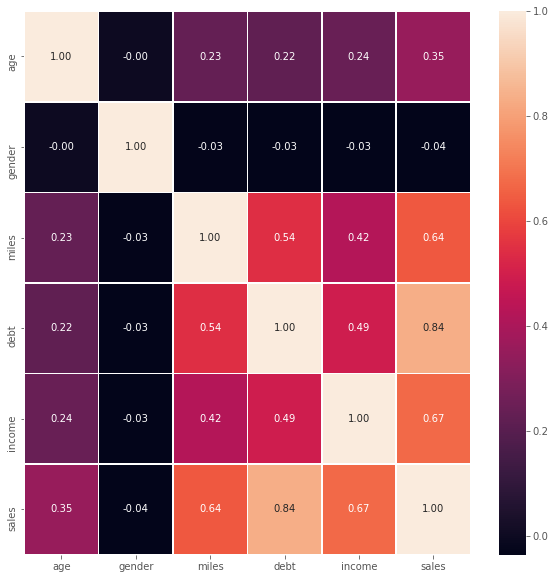

In [5]:
#Mediante el mapa observamos que caracteristicas afectan mas a las ventas
f,ax = pl.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, linewidths=0.5, fmt= '.2f',ax=ax)

Para asegurarnos, comprobaremos que la realacion indicada por seaborn es correcta mediante el comando corr(), que nos indica la correlacion que existe entre las variables

In [6]:
data.corr()# sin sns

,age,gender,miles,debt,income,sales
age,1.000000,-0.000702,0.232399,0.218896,0.239644,0.352609
gender,-0.000702,1.000000,-0.031355,-0.033181,-0.034317,-0.036350
miles,0.232399,-0.031355,1.000000,0.544791,0.422141,0.636676
debt,0.218896,-0.033181,0.544791,1.000000,0.491790,0.835541
income,0.239644,-0.034317,0.422141,0.491790,1.000000,0.674685
sales,0.352609,-0.036350,0.636676,0.835541,0.674685,1.000000


Tras conocer que caracteristicas son relevantes para hacer este estudio, eliminaremos aquellas columnas que no sean necesarias. En este caso, como hemos podido ver anteriormente, la edad y el genero no influye a la cantidad que hayan pagado por un coche

In [7]:
#Eliminamos dichas columnas
data=data.drop(columns=['age', 'gender'])

Mostramos un resumen de los valores de cada caracteristica usada para el ejercicio, y para conocer de una forma concreta como tendremos que distribuir los rangos de una forma mas correcta. Para ello nos fijaremos dentro de la columna sales, en las filas que van del min al max, y con eso definiremos los rangos.

In [8]:
data.describe()#Utilizamos describe para dividir el rango en secciones de 25%

,miles,debt,income,sales
count,963.000000,963.000000,963.000000,963.000000
mean,27.704050,14109.004154,6176.047767,11689.860852
std,13.378181,18273.702481,3260.670142,8986.896921
min,10.000000,0.000000,0.000000,500.000000
25%,20.000000,1475.000000,3506.500000,3554.000000
50%,25.000000,6236.000000,6360.000000,9130.000000
75%,32.000000,16686.000000,8649.500000,19245.000000
max,97.000000,59770.000000,11970.000000,29926.000000


Para definir los rangos, lo hacemos mediante una lista de condiciones, donde haremos referencia a cada rango de menor a mayor en un numero del 1 al 4 respectivamnete.

In [9]:
#Dividimos las ventas en 4 
conditionlist = [
    (data['sales'] >= 500.0) & (data['sales'] <=3554.0), #0-25
    (data['sales'] >= 3554.0) & (data['sales'] <=9130.0),#25-50
    (data['sales'] >= 9130.0) & (data['sales'] <=19245.0),#50-75
    (data['sales'] > 19245.0)]#75-100
choicelist = [1, 2, 3, 4]
data['sales'] = np.select(conditionlist, choicelist, default='Not Specified')
data

,miles,debt,income,sales
0,23,0,4099,1
1,27,0,2677,1
2,58,41576,6215,4
3,25,43172,7626,4
4,17,6979,8071,2
...,...,...,...,...
958,11,8778,9829,1
959,23,4850,3470,2
960,28,9312,2720,3
961,29,51343,8713,4


Una vez definidos los rangos, tenemos que señalar cuales sean nuestros datos para realizar la clasificacion. En nuestro caso, la 'y' cogera los valores de la variable sobre la que realizaremos la clasificacion, y la 'x', con el resto de caracteristicas, las cuales se utilizaran para predecir futuros valores de 'y'  

# 2. Prueba con distintas configuraciones de las dos métricas principales. La primera métrica corresponde al número de individuos que usarás para clasificar una nueva instancia y la segunda cómo vas a medir la cercanía de esa nueva instancia con el resto. ¿Qué decisiones has tomado? ¿Por qué? 

La primera configuracion que realizaremos sera de acuerdo con el numero de individuos que utilizaremos para clasificar esta nueva instancia. Para ello haremos uso del siguiente comando, para dividir los porcentajes de los individuos a utilizar para tanto clasificar como entrenar. En nuestro caso utilizaremos un 20% de los individuos para clasificar las nuevas instancias

In [10]:
#Creamos los datos con de entrenamiento y el test
x=data.drop(["sales"],axis=1)
y=data["sales"]
#80% para el training 20%para la validacion
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

Tras definir la configuración de cuantos individuos utilizaremos para clasificar las nuevas instancias, ahora pasaremos a configurar como vamos a medir la cercania entre individuos, y cual sera el numero de neighbors qeu utilizaremos. Para ello haremos uso de un algoritmo KNN, y en la primera configuracion haremos uso 20 vecinos para clasificar. 

Para definir las metricas referenciadas en el enunciado, comparando las dos configuraciones que vamos a realizar, solo variaremos el p=1 o p=2, que son distancia euclidea y manhattan respectivamente. La metrica se mantendrá la predeterminada, y veremos, para un mismo numero de vecinos cual clasifica de la mejor forma, y sera la que elegiremos de cara al siguiente apartado.

In [11]:
#Definimos el clasificador
vecinos=KNeighborsClassifier(n_neighbors=20,weights='distance',p=2,metric='minkowski')
#Entrenamos con el clasificador y los datos de entrenamiento
vecinos.fit(x_train,y_train)
#Mostramos la solucion tras la validacion
sol=vecinos.predict(x_test)
print(sol)

['1' '4' '2' '4' '3' '2' '4' '3' '3' '4' '2' '2' '2' '4' '4' '4' '4' '3'
 '2' '3' '2' '2' '3' '4' '3' '2' '4' '1' '3' '4' '3' '3' '2' '3' '1' '2'
 '3' '1' '4' '2' '1' '3' '4' '3' '2' '2' '2' '1' '4' '2' '4' '4' '3' '4'
 '4' '4' '2' '1' '1' '2' '4' '4' '3' '4' '4' '4' '1' '2' '2' '4' '4' '4'
 '4' '2' '2' '3' '1' '2' '4' '1' '4' '2' '4' '3' '1' '3' '3' '1' '1' '1'
 '4' '4' '2' '3' '1' '3' '3' '2' '4' '4' '2' '4' '3' '4' '4' '3' '4' '1'
 '1' '2' '2' '3' '3' '4' '1' '4' '3' '3' '3' '4' '1' '1' '4' '1' '2' '3'
 '2' '3' '3' '3' '1' '3' '3' '2' '3' '1' '4' '3' '1' '2' '4' '4' '3' '2'
 '1' '3' '3' '2' '4' '2' '4' '2' '3' '4' '3' '2' '4' '1' '1' '1' '1' '3'
 '3' '1' '2' '4' '1' '1' '3' '1' '2' '1' '1' '3' '4' '4' '4' '4' '1' '1'
 '2' '1' '4' '1' '4' '2' '2' '3' '1' '4' '2' '1' '2']


In [12]:
print("Accuracy:",metrics.accuracy_score(y_test,sol))
print("Error:",1-metrics.accuracy_score(y_test,sol))

Accuracy: 0.694300518134715
Error: 0.30569948186528495


Tras obtener un accuracy bajo para un numero alto de neighbors, comprobaremos si para la distancia de manhattan mejora esta precision. Haremos uso de la que mejor precision tenga a la hora de clasificar para el numero de vecinos indicado.

In [13]:
#Definimos el clasificador
vecinos2=KNeighborsClassifier(n_neighbors=20,weights='distance',p=1,metric='minkowski')
#Entrenamos con el clasificador y los datos de entrenamiento
vecinos2.fit(x_train,y_train)
#Mostramos la solucion tras la validacion
sol2=vecinos2.predict(x_test)
print(sol2)

['1' '4' '2' '4' '3' '2' '4' '3' '3' '4' '2' '2' '3' '4' '4' '4' '4' '3'
 '2' '3' '2' '2' '3' '4' '3' '2' '4' '1' '3' '4' '3' '3' '2' '1' '1' '2'
 '3' '1' '4' '2' '1' '3' '4' '3' '2' '2' '2' '1' '4' '2' '4' '4' '3' '4'
 '4' '4' '2' '1' '1' '2' '4' '4' '2' '4' '4' '4' '1' '2' '2' '4' '4' '4'
 '4' '2' '2' '3' '1' '2' '4' '1' '4' '1' '4' '3' '1' '3' '3' '1' '1' '1'
 '4' '4' '2' '3' '2' '3' '3' '2' '4' '4' '2' '4' '3' '4' '4' '3' '4' '1'
 '1' '2' '2' '3' '3' '4' '1' '4' '3' '3' '3' '4' '1' '1' '4' '1' '2' '3'
 '2' '3' '3' '3' '1' '3' '3' '2' '3' '1' '4' '3' '1' '2' '4' '4' '3' '2'
 '1' '3' '3' '2' '4' '2' '4' '2' '3' '4' '3' '2' '4' '1' '1' '1' '1' '3'
 '3' '1' '2' '4' '1' '1' '3' '1' '2' '2' '1' '4' '4' '4' '4' '4' '1' '1'
 '2' '1' '4' '1' '4' '2' '2' '3' '1' '4' '2' '1' '2']


In [14]:
print("Accuracy:",metrics.accuracy_score(y_test,sol2))
print("Error:",1-metrics.accuracy_score(y_test,sol2))

Accuracy: 0.7150259067357513
Error: 0.2849740932642487


Como podemos ver, tras introducir las metricas referenciadas en el enunciado, introducimos dentro de los nuevos parametros, donde varia p=2 haciendo referencia a la distancia euclidea, y p=1, haciendo referencia a la distancia de manhattan. Como podemos ver, para el mismo numero de neighbors, tiene mejor precision con p=1, por lo que para el siguiente apartado, haremos uso de la distancia de manhatan con la metrica predeterminada de 'minkowski'. 

Cuando ya sabemos que metrica usar, identificaremos para que numero de neighbors es mejor la clasificacion. En este caso, comprobaremos que para 50 neighbors adquiriremos un accuracy mas alto. Por lo que a mayor numero de vecinos, mejor precision.

In [15]:
#Definimos el clasificador despues explicaremos la razon por la que hemos escogido 50
knn=KNeighborsClassifier(n_neighbors=50,weights='distance',p=1,metric='minkowski')
#Entrenamos con el clasificador y los datos de entrenamiento
knn.fit(x_train,y_train)
#Mostramos la solucion tras la validacion
pred=knn.predict(x_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test, pred))
print("Accuracy:",metrics.accuracy_score(y_test,pred))

[[33 10  4  0]
 [ 7 23 13  0]
 [ 2 10 30  3]
 [ 0  1  3 54]]
              precision    recall  f1-score   support

           1       0.79      0.70      0.74        47
           2       0.52      0.53      0.53        43
           3       0.60      0.67      0.63        45
           4       0.95      0.93      0.94        58

    accuracy                           0.73       193
   macro avg       0.71      0.71      0.71       193
weighted avg       0.73      0.73      0.73       193

Accuracy: 0.7253886010362695


Finalmente, tras comprobar, que el menor numero de vecinos es 50, tras realizar la comprobacion de las metricas, hemos determinado que la distancia euclidea será mas precisa, por que cada vez que aumenta el numero de neigbors, la distancia euclidea va siendo menor por lo que obtendrá una mayor precision

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

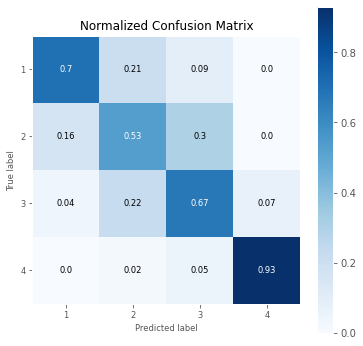

In [16]:
skplt.metrics.plot_confusion_matrix(y_test, knn.predict(x_test),normalize=True,figsize=(6,6),text_fontsize='small')

Como podemos ver, a mayor numero de vecinos para entrenar hasta cierto punto, mejor accuracy, por lo que haremos uso de valores altos de numero de vecinos para poder hacer la clasificacion mas correcta posible.

# 3. Elige la mejor configuración entre las anteriores. Para ello dibuja una tabla ver cómo evoluciona la clasificación.  Dibuja  los  resultados  que  se  obtienen  con  ambas  configuraciones  elegidas  cómo  las mejores

In [17]:
#Creamos variables donde se guardaran los datos del error y del numero de neighbours
#error
numero=list(range(1, 101))

#numero de 1 a 30
error = []
error = list()

In [20]:
vecinos2=KNeighborsClassifier(n_neighbors=50,weights='distance',p=1,metric='minkowski')
    #Entrenamos con el clasificador y los datos de entrenamiento
vecinos2.fit(x_train,y_train)
    #Mostramos la solucion tras la validacion
sol=vecinos2.predict(x_test)
precision=metrics.accuracy_score(y_test,sol)
    #Calculamos el error
errorprueba=1-precision
errorprueba


0.27461139896373055

In [21]:
#Creamos un bucle que realice 30 iteraciones empezando en 1 y acabando en 31(31 no incluido) 
#para que se pueda ver el error que se obtiene al aumentar el numero de vecinos
for i in range (1,101):
    #Definimos el clasificador
    vecinos2=KNeighborsClassifier(n_neighbors=i)
    #Entrenamos con el clasificador y los datos de entrenamiento
    vecinos2.fit(x_train,y_train)
    #Mostramos la solucion tras la validacion
    sol=vecinos2.predict(x_test)
    precision=metrics.accuracy_score(y_test,sol)
    #Calculamos el error
    errorpreci=1-precision
    error.append(errorpreci)


In [22]:
#Creacion de la tabla donde se muestra la disminucion del error al aumentar el numero de vecinos hasta cierto punto
# El punto en el que vuelve a aumentar el error es el numero 50
tabla = pd.DataFrame({"Neighbours": numero,"Error": error})
tabla

,Neighbours,Error
0,1,0.321244
1,2,0.388601
2,3,0.367876
3,4,0.404145
4,5,0.326425
...,...,...
95,96,0.326425
96,97,0.326425
97,98,0.326425
98,99,0.331606


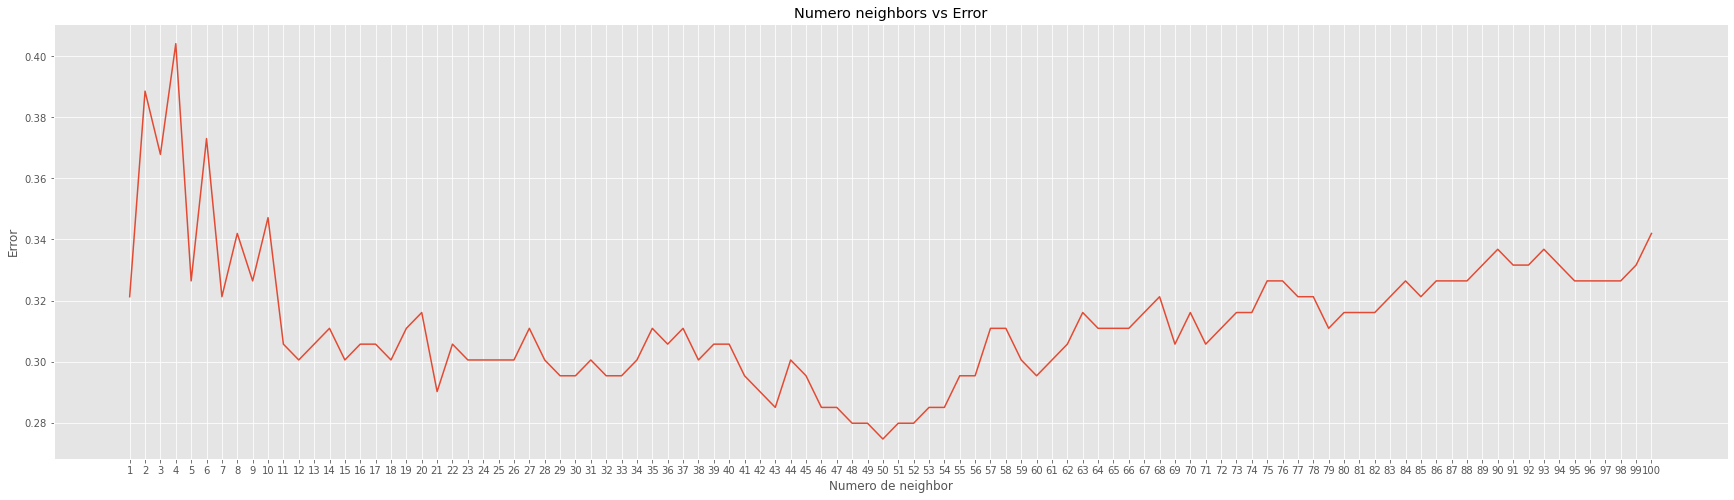

In [23]:
#Grafica que muestra la disminucion y el posterior aumento del error
pl.figure(figsize=(30,8))
pl.plot(numero, error)
pl.title('Numero neighbors vs Error')
pl.xticks(numero)
pl.xlabel('Numero de neighbor')
pl.ylabel('Error')
pl.show()

Como podemos ver al aumentar el numero de neighbours el error desciende dado que aumenta la precision

# 4. Utiliza  el  clasificador  para  saber  que  ocurre  con  los datos  de  un  nuevo dataset  que  se  llame “dispuestoapagar_clasificar.csv” que obtendremos del dataset proporcionado

In [24]:
test=data.tail(193)
test

,miles,debt,income,sales
770,22,8096,5276,3
771,21,45358,7340,4
772,26,8464,7632,3
773,47,2303,8605,3
774,30,1982,6355,2
...,...,...,...,...
958,11,8778,9829,1
959,23,4850,3470,2
960,28,9312,2720,3
961,29,51343,8713,4


In [25]:
test.to_csv('dispuestoapagar_clasificar.csv', index=False)

#Leemos los datos del csv creado
data=pd.read_csv("dispuestoapagar_clasificar.csv")#Leemos el fichero csv
data

In [26]:
#Creamos los datos con de entrenamiento y el test
x_test=test.drop(["sales"],axis=1)
y_test=test["sales"]

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

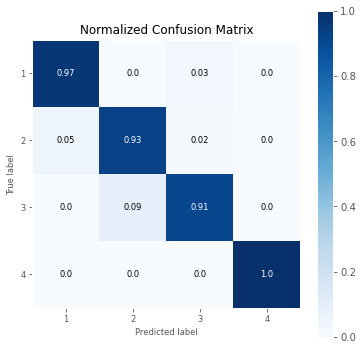

In [27]:
skplt.metrics.plot_confusion_matrix(y_test, knn.predict(x_test),normalize=True,figsize=(6,6),text_fontsize='small')

In [28]:
confusion_matrix(knn.predict(x_test), y_test)

array([[37,  3,  0,  0],
       [ 0, 51,  5,  0],
       [ 1,  1, 51,  0],
       [ 0,  0,  0, 44]], dtype=int64)

params = {'n_neighbors':numero}

knn = KNeighborsClassifier()

model = GridSearchCV(knn, params, cv=5)
model.fit(x_train,y_train)
model.best_params_
